In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from functools import reduce
import re as re
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
import warnings
warnings.filterwarnings('ignore')
sns.set()
plt.style.use('fivethirtyeight')

In [ ]:
# Loading all "csv" files.
# I named the files as per the orginal name associated with "csv" files.
framenames =[]
varsname =[]
for file in os.listdir("DataSet"):    
    if file.endswith(".csv"):
        filepath = os.path.join("DataSet", file)
        name = [i.split(".") for i in file.split("_")]
        name = reduce(lambda x, y: x + y ,name)[:-1]
        name = "_".join(name)
        vars()[name] = pd.read_csv(filepath, encoding = 'unicode_escape')
        print(name)
        framenames.append(name)
        varsname.append(vars()[name])

credit_card_balance


In [3]:
train = pd.read_csv("DataSet/application_train.csv")

In [4]:
test = pd.read_csv("DataSet/application_test.csv")

In [5]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [ ]:
application_test = reduce_mem(application_test)
HomeCredit_columns_description = reduce_mem(HomeCredit_columns_description )
POS_CASH_balance = reduce_mem(POS_CASH_balance)
credit_card_balance = reduce_mem(credit_card_balance)
installments_payments = reduce_mem(installments_payments)
application_train = reduce_mem(application_train)
bureau= reduce_mem(bureau)
previous_application = reduce_mem(previous_application )
bureau_balance = reduce_mem(bureau_balance)

In [6]:
test = reduce_mem(test)
train = reduce_mem(train)

Memory usage of dataframe is 45.00 MB
Memory usage after optimization is: 14.60 MB
Decreased by 67.6%
Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 92.38 MB
Decreased by 67.7%


In [ ]:
dfs =  [application_test,HomeCredit_columns_description,POS_CASH_balance,credit_card_balance,installments_payments,
       application_train,bureau, previous_application, bureau_balance, sample_submission]



## EDA of application_train

#### Exploring the missing values

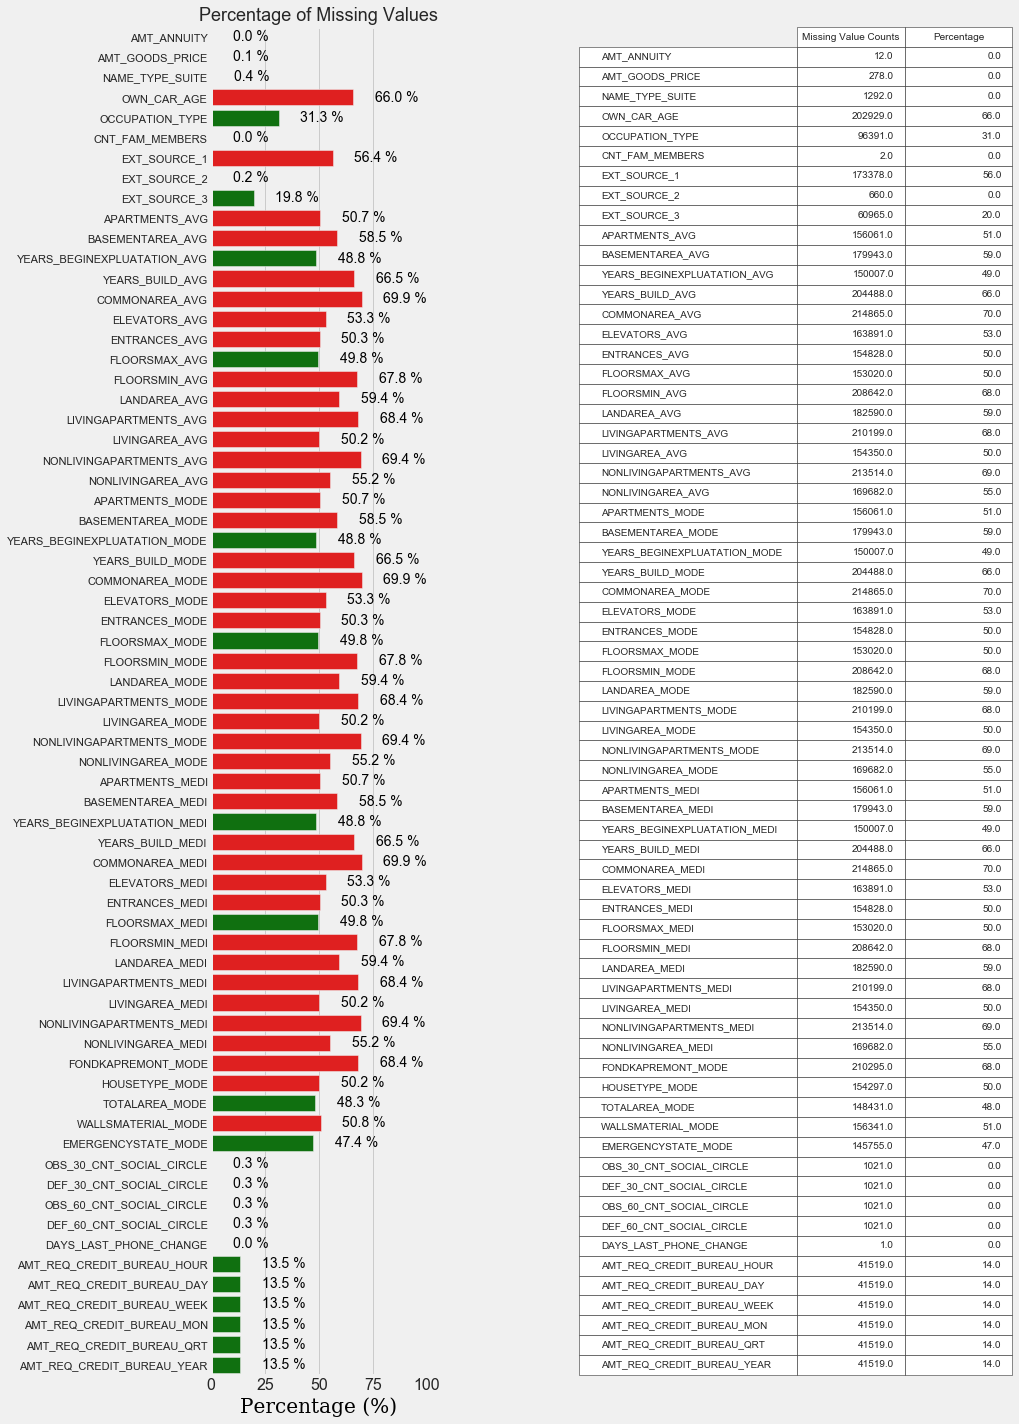

In [63]:
def missing_values(df, figsize=(10, 20)):
    plt.style.use('fivethirtyeight')
    misval= df.isnull().sum()
    df_misval = pd.DataFrame(misval[misval!=0])
    df_misval.columns = ['frequency']
    df_misval["percentage"] = (df_misval/len(df))*100
    #df_misval =df_misval
    
    # If there are more than 50 % values are missing, it will appear as red. 
    colors = ['red' if (x > 50.00) else 'green' for x in df_misval['percentage']]
    # Now Plotting missing values as well as the dataframe
    f, (ax1, ax2) = plt.subplots(1,2, figsize=figsize)

    b= sns.barplot(x= "percentage", y = df_misval.index,
                data = df_misval, palette=colors, label = "biggest", ax = ax1)
    font = {'family': 'serif','color':  'black', 'weight': 'normal','size': 20}
    b.set_xlim(0,100)
    b.set_xlabel("Percentage (%)", fontdict = font)
    b.set_title("Percentage of Missing Values", fontsize = 18)
    
    # Annotaing the acutal number
    for index, row in df_misval.reset_index().iterrows():
        b.text(10+row.percentage,row.name, str(round(row.percentage,1)) + " %", color='black', va="center")
    ax1.tick_params(axis = 'x', which = 'both', labelsize = 16)

    # adding the data frame as a subplot
    bbox=[1.5, 0, 1, 1]
    ax2.axis('off')
    mpl_table = ax2.table(cellText = np.round(df_misval.values),
                          rowLabels = df_misval.index,
                         bbox = bbox, colLabels=["Missing Value Counts", "Percentage"],
                          colLoc='center')
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(10)
    #sns.set(font_scale = 1)

    plt.rc("font")
    plt.tight_layout()
    f.tight_layout()
    plt.savefig("missing_values.pdf", dpi=300,
                bbox_extra_artists=(b, mpl_table), bbox_inches='tight' )
    
    return ax1, ax2

ax1,ax2 = missing_values(train)

There are lot of missing values; for some columns it is over 50% (shown as red). we need to deal with the missing values before building up machine learning models and we need to deal with it separately for int and object columns. So let's see what object columns contain missing values:


##### Missing values for object  or categorical columns

(<matplotlib.axes._subplots.AxesSubplot at 0x1a13e8a5f8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a166a66d8>)

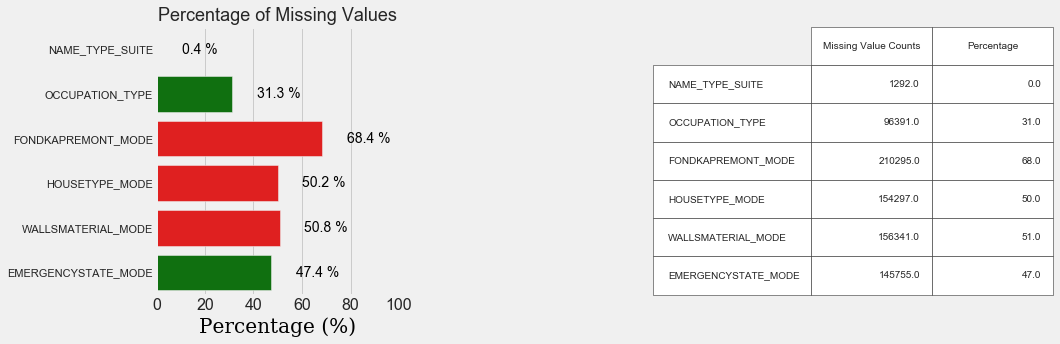

In [64]:
missing_values(train.select_dtypes(include ="object"),figsize=(10,5))

##### Distribution of unique classes in object columns

Number of Unique categories in the object columns: 

 NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                8
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               19
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             5
HOUSETYPE_MODE                 4
WALLSMATERIAL_MODE             8
EMERGENCYSTATE_MODE            3
dtype: int64 

Distribution of Category Variables:



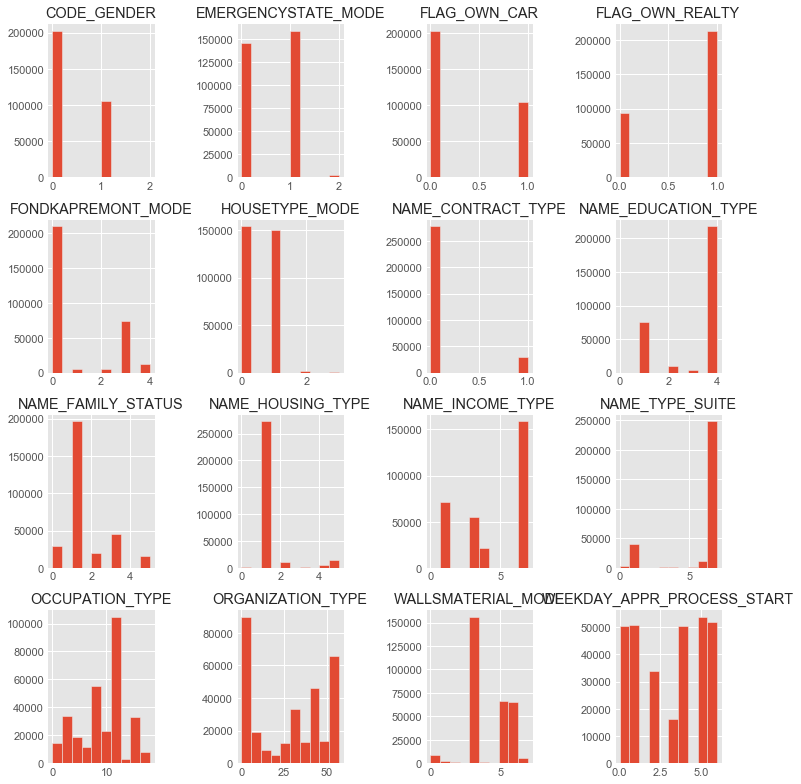

In [65]:
def category_distribution(df):
    # Selecting object columns
    plt.style.use('ggplot')
    le = LabelEncoder()
    train_object = df.select_dtypes(include ="object")
    object_columns = df.select_dtypes(include ="object").columns
    # Converting np.nan to "NAN"
    for i in object_columns:
        train_object[i].replace(np.nan, 'NaN', inplace=True)
    # Applying label_encoder
    train_object_le= train_object.apply(le.fit_transform)

    train_object_le.hist(figsize=[11,11])
    plt.tight_layout()
    # Number of unique classes in each class object
    print("Number of Unique categories in the object columns:",
          "\n\n",train_object.apply(pd.Series.nunique, axis = 0),"\n")
    print("Distribution of Category Variables:\n")
category_distribution(train)

#### Clearly the categories in the object columns are not balanced except the "WEEKDAY_APPR_PROCESS_START". 

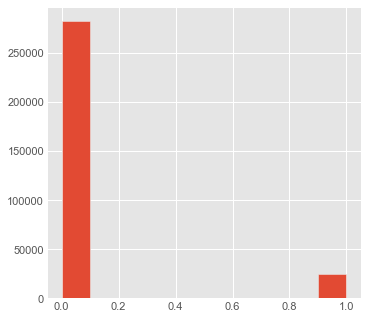

In [55]:
# Distribution of target variables
train.TARGET.hist(figsize=[5,5])


##### We need to deal with category variables. We will use both LabelEncoder (for columns with two catergories) and OneHotEncoder ( for the rest)


#### Distribution of target variables are not balanced as well, so we need to do some operations. 

In [ ]:
train= application_train.copy()
test = application_test.copy()
#pd.get_dummies(train).shape, pd.get_dummies(test).shape

In [7]:
def encode(df):
    le = LabelEncoder()
    oe = OneHotEncoder()
    le_col=[]
    for col in df:
        if df[col].dtype =="object":
            if df[col].nunique()==2:
                df[col].replace(np.nan, "NAN", inplace=True)
                le_col.append(col)
                le.fit(df[col])
                df[col] = le.transform(df[col])
    print("These {} columns ({}) are label encoded".format(len(le_col), le_col))
    print("Dimensions before OneHotEncoding : {}".format(df.shape))
    df = pd.get_dummies(df)
    print("Dimensions after OneHotEncoding : {}".format(df.shape))
    
    return df
                
train =encode(train)
train.head()


These 4 columns (['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'EMERGENCYSTATE_MODE']) are label encoded
Dimensions before OneHotEncoding : (307511, 122)
Dimensions after OneHotEncoding : (307511, 242)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden
0,100002,1,0,0,1,0,202500.0,406597.5,24700.5,351000.0,...,1,0,0,0,0,0,0,0,1,0
1,100003,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,1,0,0,1,0,0,0,0,0,0
2,100004,0,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,0,0,1,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
test = encode(test)
test.head()

These 5 columns (['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'EMERGENCYSTATE_MODE']) are label encoded
Dimensions before OneHotEncoding : (48744, 121)
Dimensions after OneHotEncoding : (48744, 237)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden
0,100001,0,0,0,1,0,135000.0,568800.0,20560.5,450000.0,...,1,0,0,0,0,0,0,0,1,0
1,100005,0,1,0,1,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0,0,0,0,0,0
2,100013,0,1,1,1,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0,0,0,0,0,0
3,100028,0,0,0,1,2,315000.0,1575000.0,49018.5,1575000.0,...,1,0,0,0,0,0,0,1,0,0
4,100038,0,1,1,0,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,0,0,0,0,0,0


#### It looks like the dimensions of train and test data are not same, which is because of some categorical object didn't show up in the test data. So we need to aling train and test data. 

In [9]:
def align(train, test):
    
    print(" Shape of train data before alinging: {}".format(train.shape),"\n", 
         "Shape of test data before alinging: {}".format(test.shape))
    target = train["TARGET"]
    train, test = train.align(test, join="inner", axis =1)
    train["TARGET"] = target
    print(" Shape of train data after alinging: {}".format(train.shape), "\n", 
     "Shape of test data after alinging: {}".format(test.shape))
    return train, test
train, test = align(train, test)

 Shape of train data before alinging: (307511, 242) 
 Shape of test data before alinging: (48744, 237)
 Shape of train data after alinging: (307511, 237) 
 Shape of test data after alinging: (48744, 236)


In [ ]:
sns.boxplot(x= train['DAYS_EMPLOYED']/365)

#### Anomalies in Data

There are more than 100 features, so checking the description of each column to find anomalies is not feasible. Fishing out the outliers by z-score could be a way to go, but there are some features such as income and debt which contain values significantly higher than the mean, and these are real! We can try to visualize all the data, hoping if there are any anomalies, it will be detected upon inspection. Additionally,  it will give us idea about the data more clearly. 

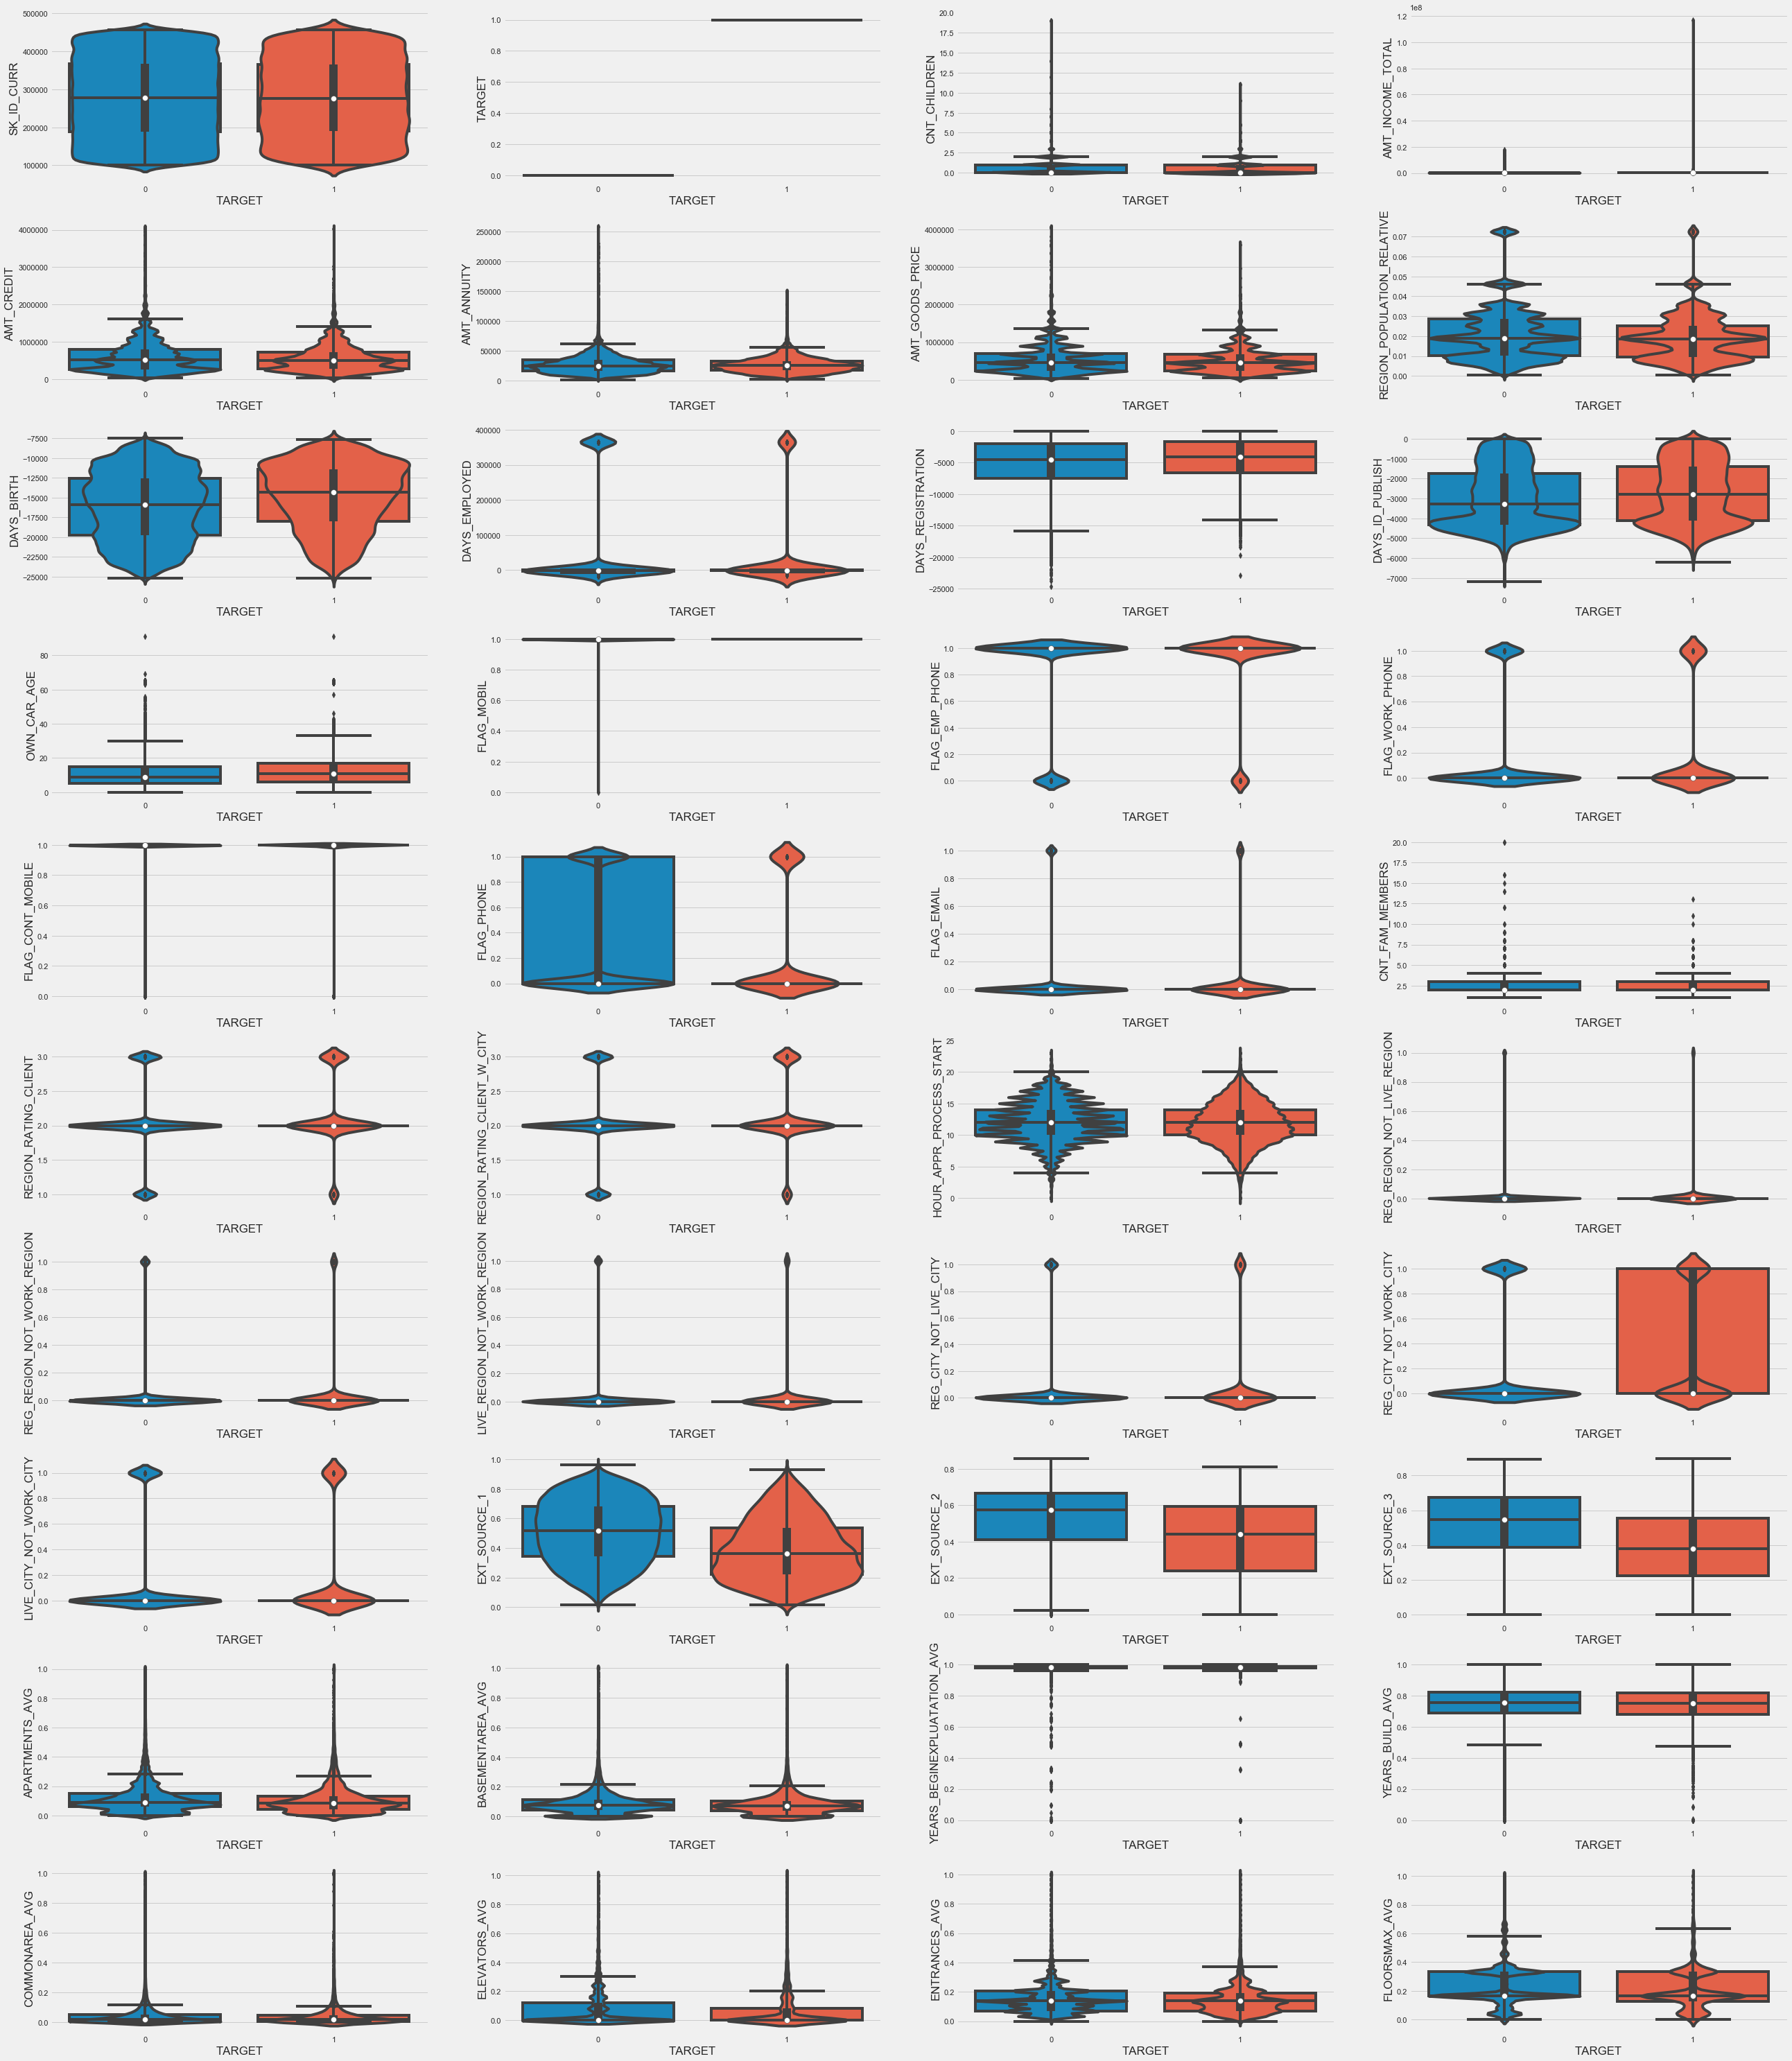

In [27]:
def violinplot(df, cols):
    """
    This will plot both violin and box plot on top of each othere for 
    each features, which would be better to understand the data,
    for the categories of the target variable.
    The dataframe has to contain 40 features to use this function.
    """
    
    plt.figure(figsize =(40,50))
    for idx, ft in enumerate(cols):
        plt.subplot(len(cols)/4,4, idx+1)
        sns.violinplot(y=df[ft], x=df["TARGET"])
        sns.boxplot(y=df[ft], x=df["TARGET"])

cols = train.select_dtypes(exclude ="object").columns
violinplot(train, num_cols[:40])

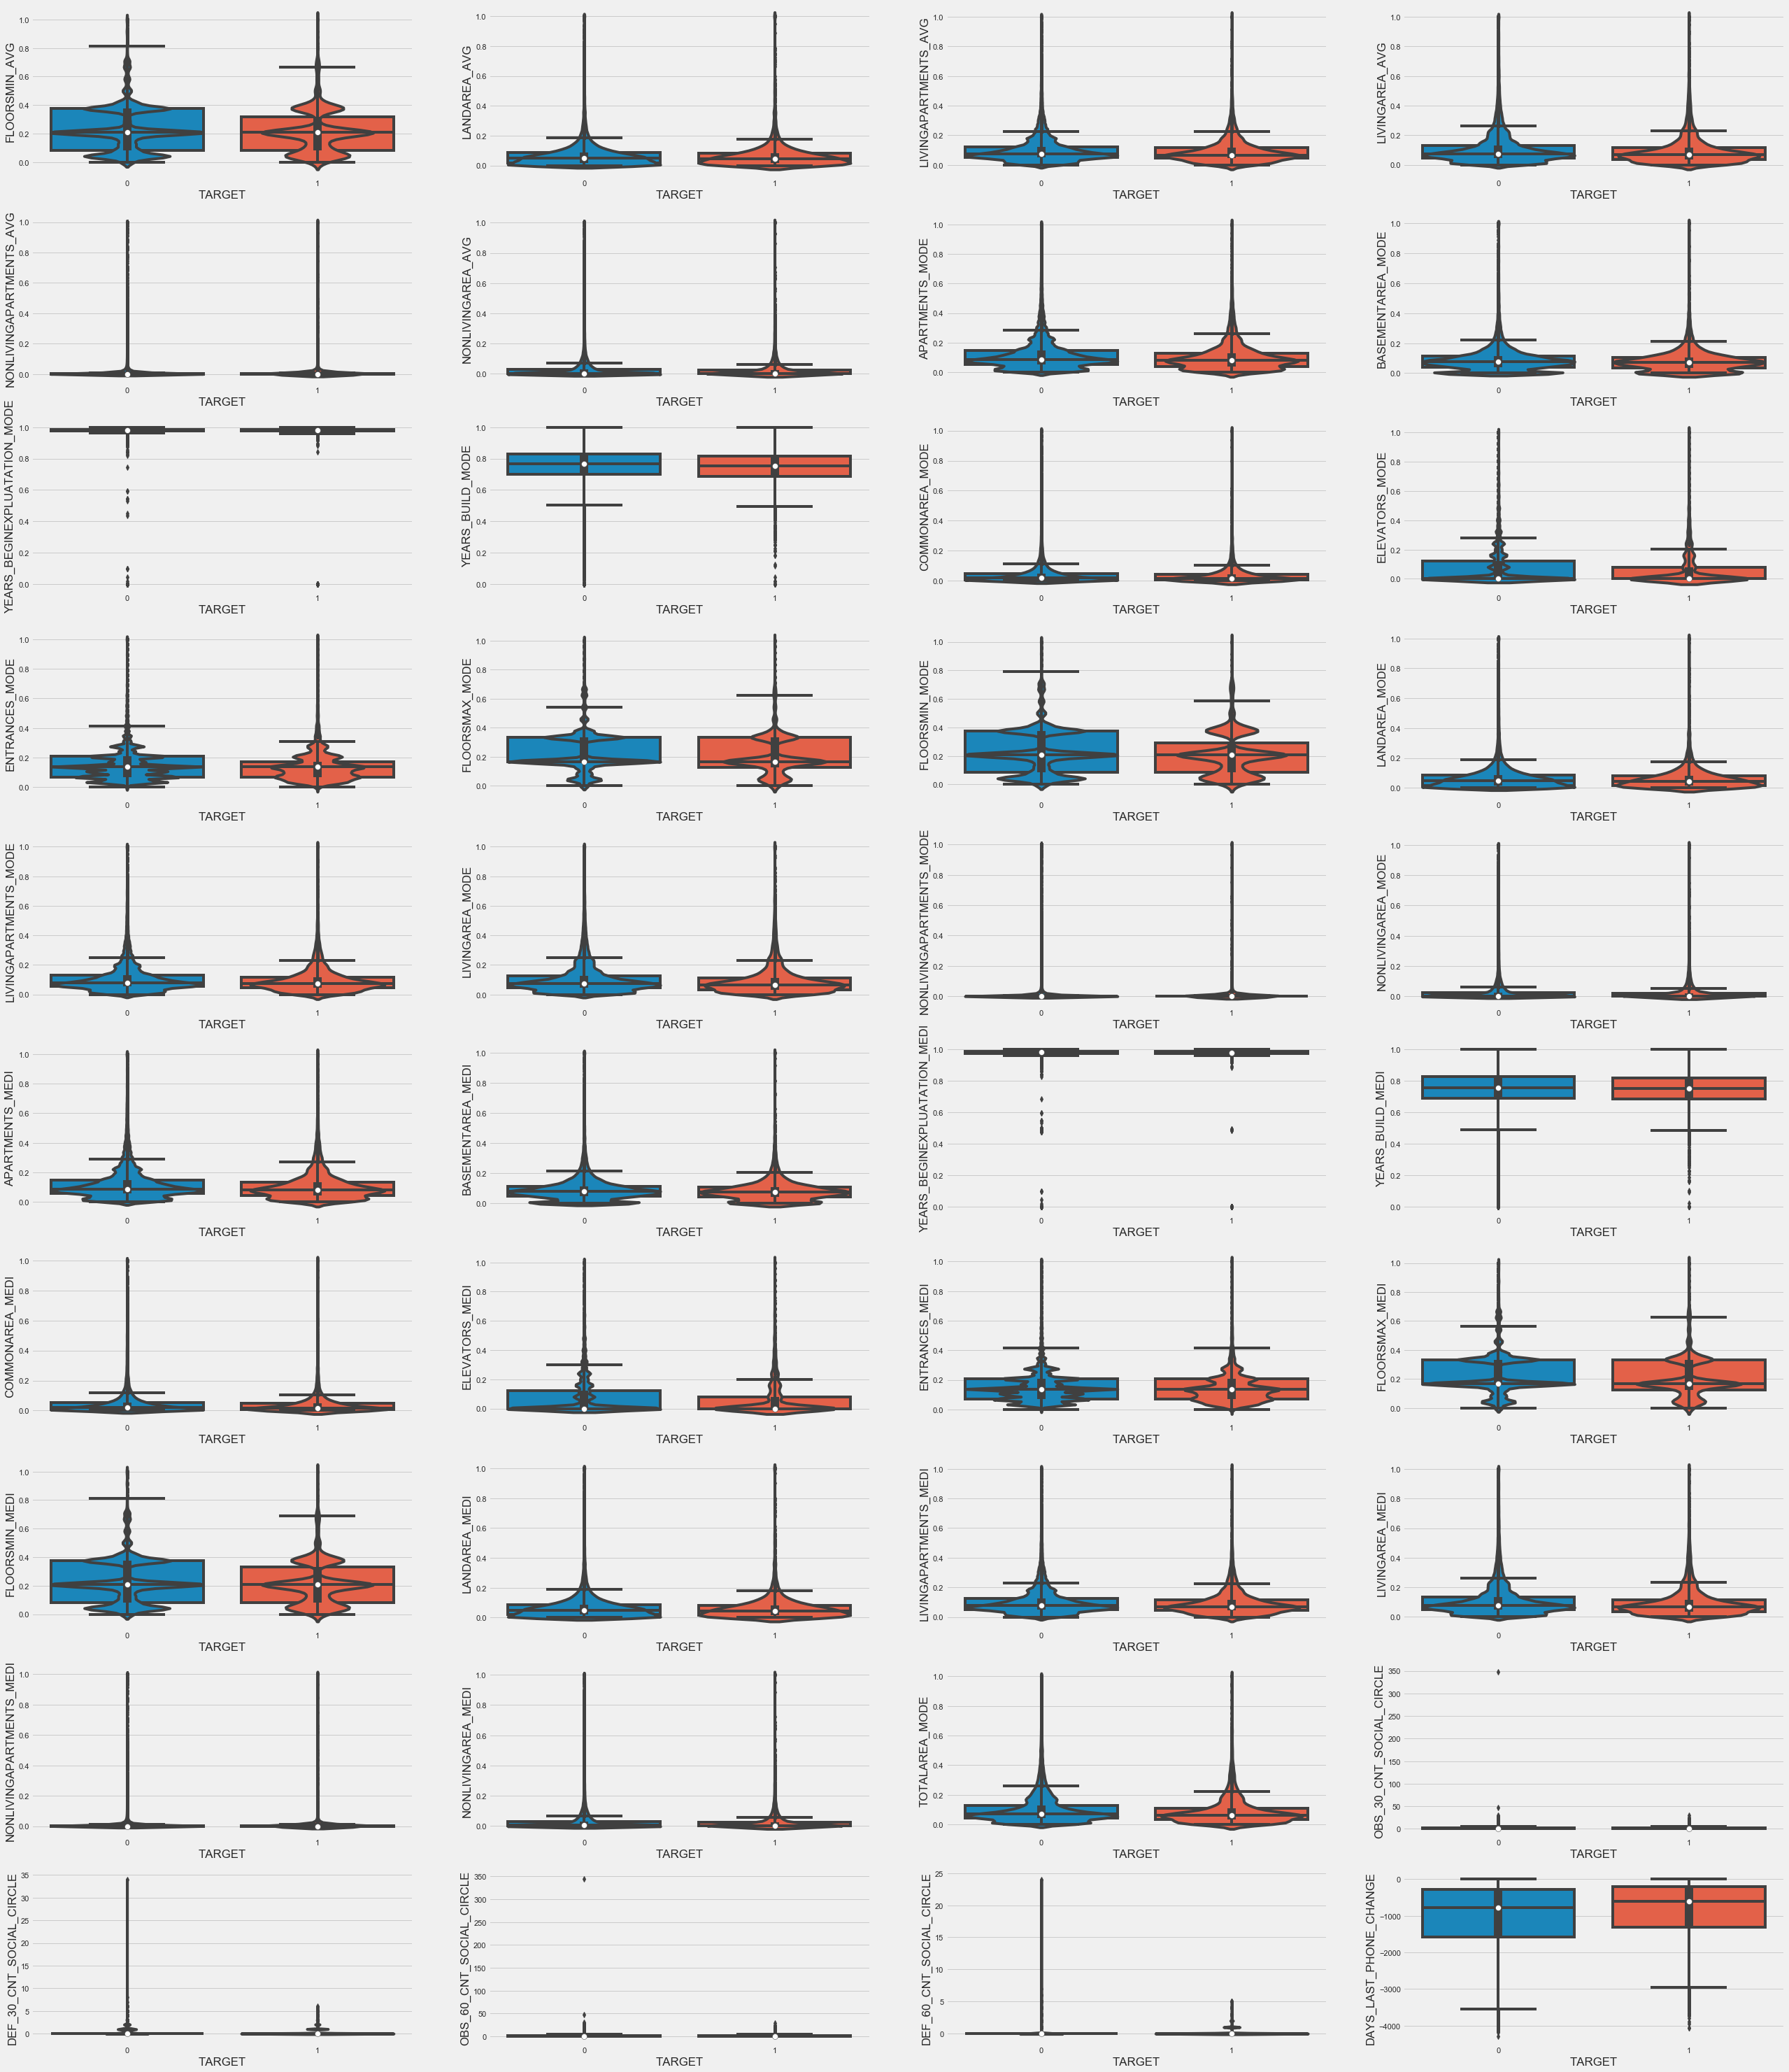

In [41]:
violinplot(train, num_cols[40:80])

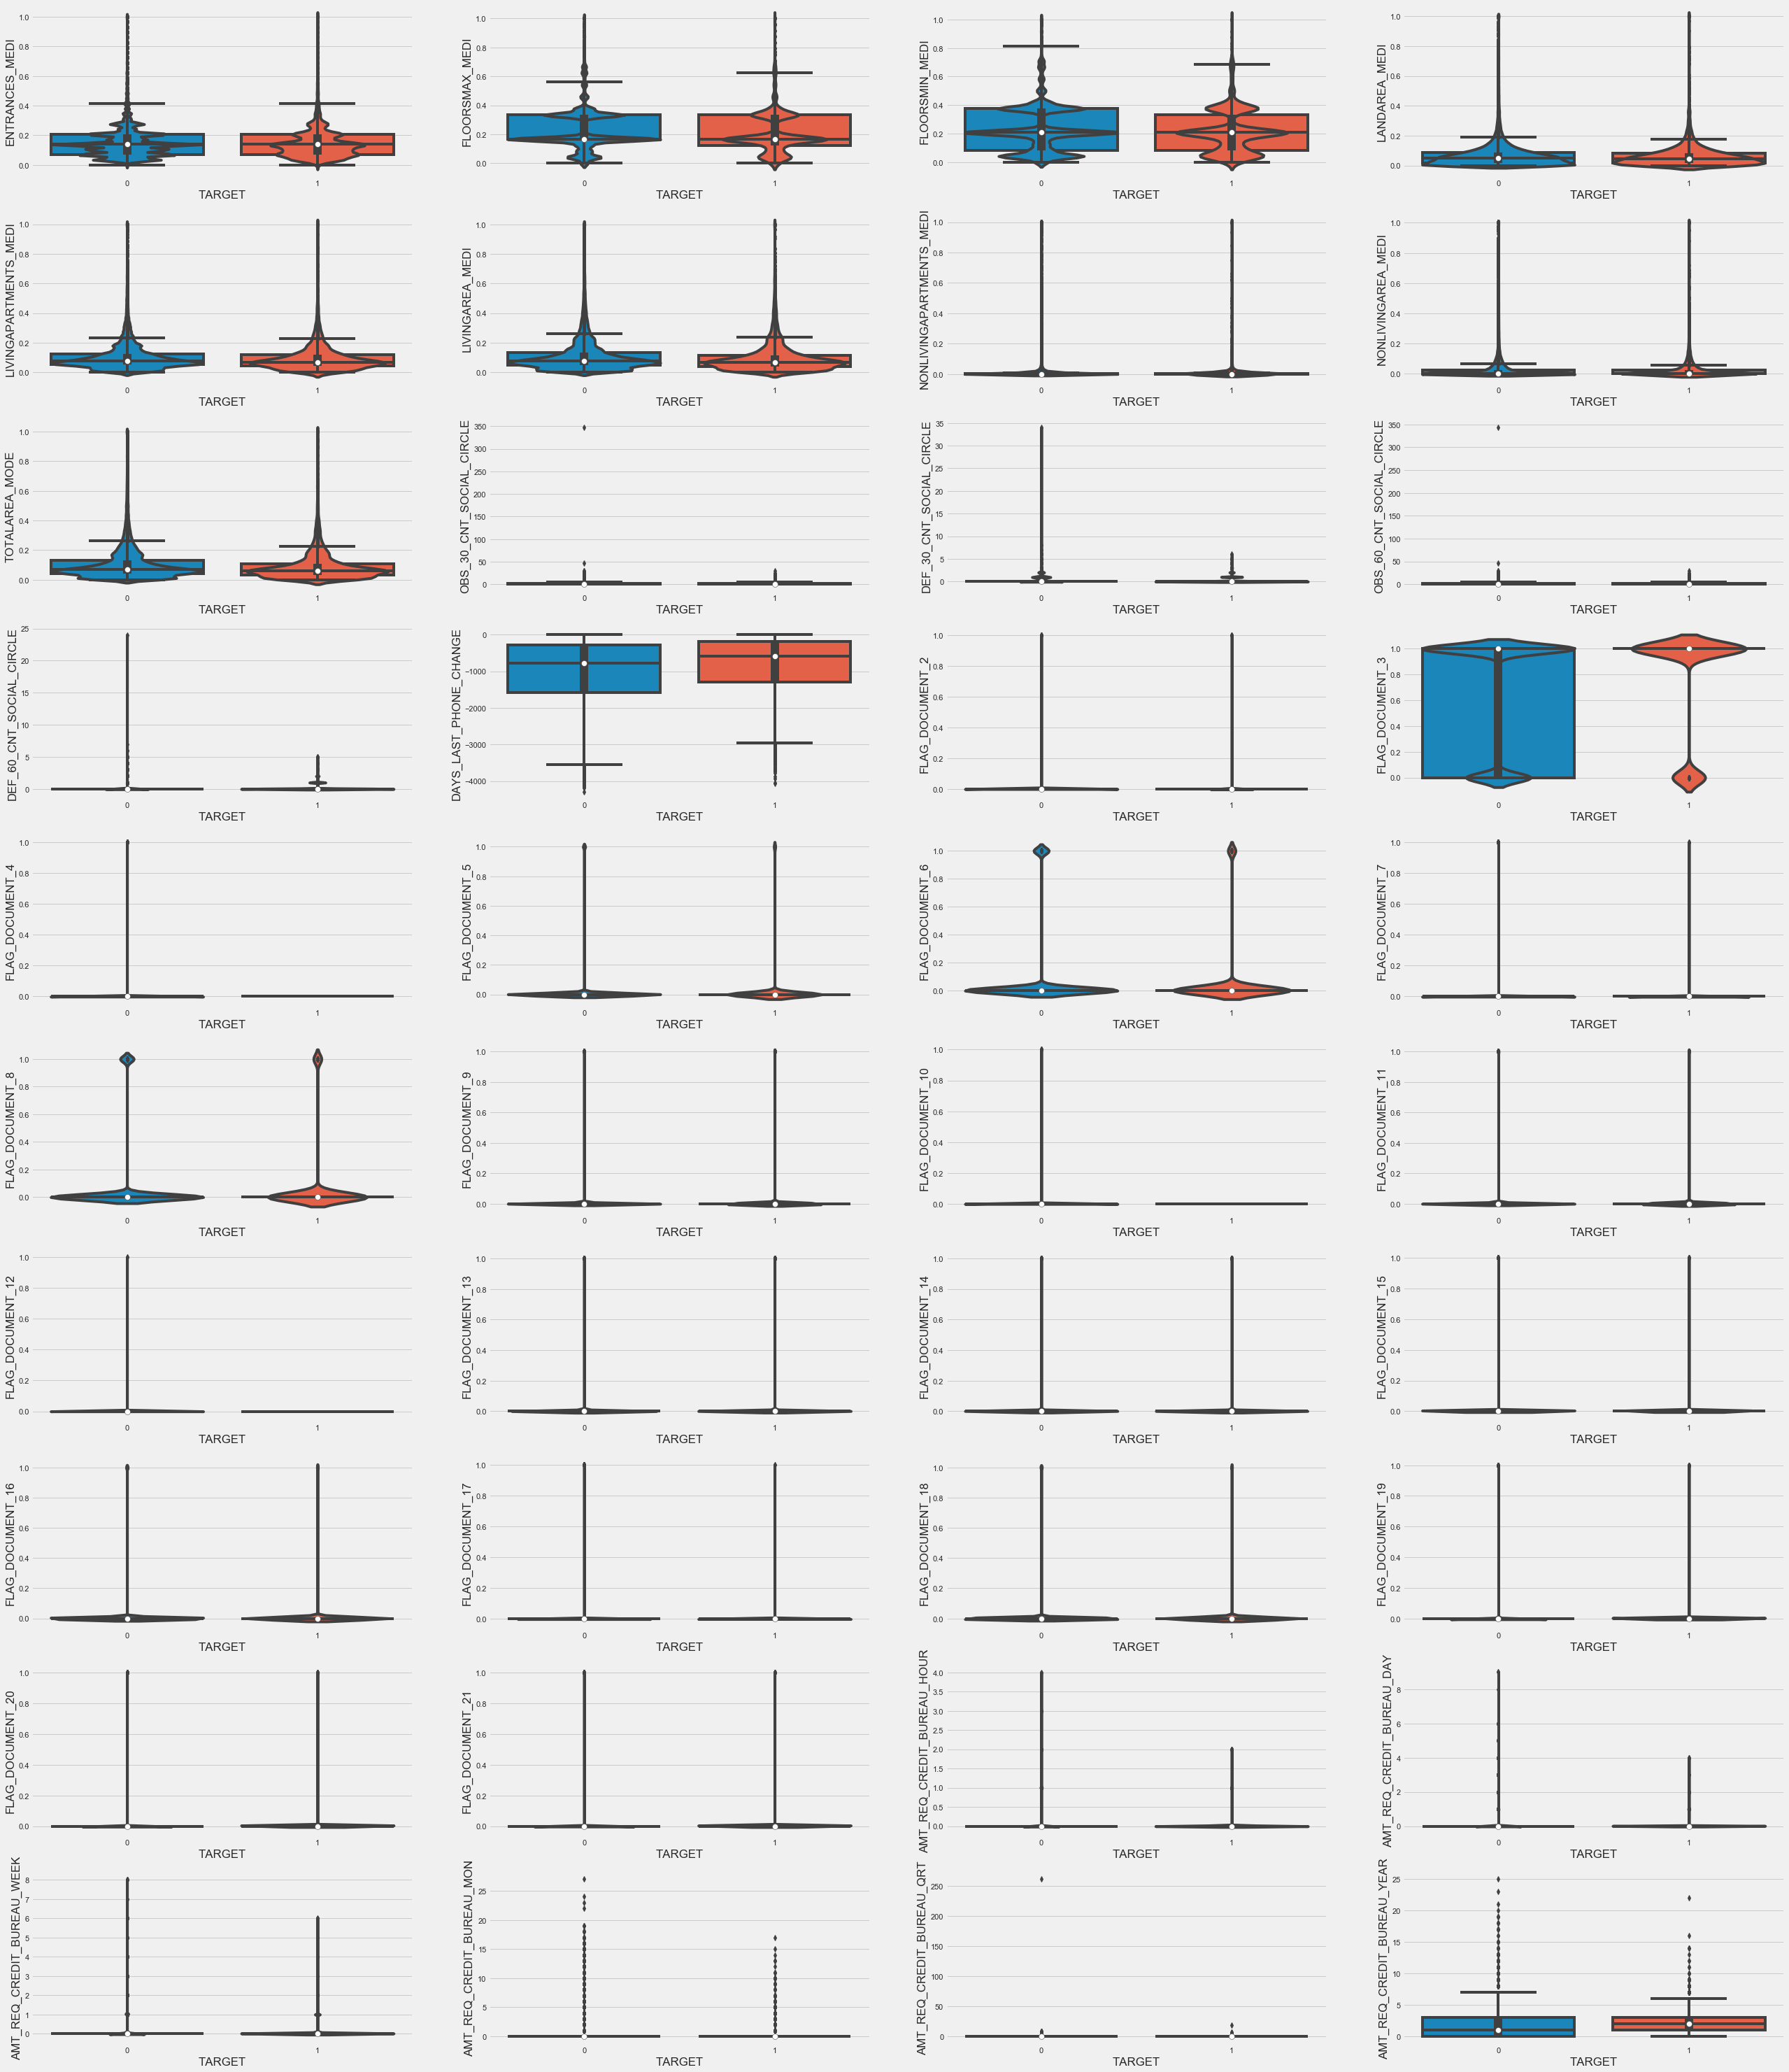

In [42]:
violinplot(train, num_cols[66:])

It looks like the feature 'DAYS_EMPLOYED' may have some issues, which is clearly showing two distributions. Let's look it more closely. 

Text(0.5,0,'Years Employed')

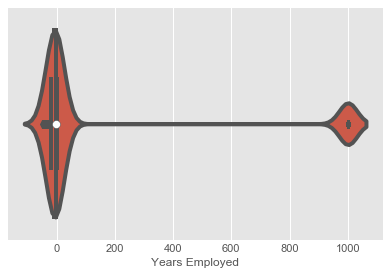

In [71]:
sns.violinplot(x= train['DAYS_EMPLOYED']/365);
sns.boxplot(x= train['DAYS_EMPLOYED']/365)
plt.xlabel("Years Employed")

1000 years employment doesn't make sense! And, there are two distributions.  
Thanks to Will Koehrsen (https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction), who pointed out that this anomaly could have some value in machine learning. Let's look at this. 

In [10]:
anom = train[train['DAYS_EMPLOYED'] == 365243]
non_anom = train[train['DAYS_EMPLOYED'] != 365243]

print('The non-anomalies default on {} of loans'.format(np.round(100 * non_anom['TARGET'].mean(),2)))
print('The anomalies default on {}  of loans'.format(np.round(100 * anom['TARGET'].mean(),2)))
print('There are {}  anomalous days of employment'.format(len(anom)))
      


The non-anomalies default on 8.66 of loans
The anomalies default on 5.4  of loans
There are 55374  anomalous days of employment


In [11]:
# Making a new column for anomalies, which will be used in our machine learning model, and replacing it with NaN
def anomaly_correction(df, feature = "DAYS_EMPLOYED", integer=365243):
    df['anl'] = (df[feature]==integer).astype(int)

    df[feature].replace({integer: np.nan}, inplace =True )
    return df
train = anomaly_correction(train, feature = "DAYS_EMPLOYED", integer=365243)
test = anomaly_correction(test, feature = "DAYS_EMPLOYED", integer=365243)

It looks like the values of the features "DAYS_EMPLOYED" and "DAYS_BIRTH" are negative, which doesn't make sense. 
Let's make them positive.


In [119]:
train[["DAYS_EMPLOYED","DAYS_BIRTH"]] = train[["DAYS_EMPLOYED","DAYS_BIRTH"]].apply(lambda x: x*(-1))
test[["DAYS_EMPLOYED","DAYS_BIRTH"]]= test[["DAYS_EMPLOYED","DAYS_BIRTH"]].apply(lambda x: x*(-1))

#### Now we will look into some features with relative high importance with respect to target variable through correlation function (though it is not a great way to understand the importance). 

In [121]:
corr = train.corr()['TARGET'].sort_values()
print("Positively correlated features are:\n",corr.tail(20))
print("Negatively correlated features are:\n",corr.head(20))

Positively correlated features are:
 ORGANIZATION_TYPE_Self-employed                      0.029139
NAME_HOUSING_TYPE_With parents                       0.029966
OCCUPATION_TYPE_Drivers                              0.030303
DEF_60_CNT_SOCIAL_CIRCLE                             0.031276
DEF_30_CNT_SOCIAL_CIRCLE                             0.032248
LIVE_CITY_NOT_WORK_CITY                              0.032518
OWN_CAR_AGE                                          0.037612
DAYS_REGISTRATION                                    0.041975
OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
DAYS_LAST_PHONE_CHANGE           

Now let's know more about top 4 features both directly and inversly correlated with the target variables.

In [12]:
def kdeplot(df, feature_list = None, plot_style = 'fivethirtyeight' ): 
    plt.style.use(plot_style)
    plt.figure(figsize =(8,18))
    for idx, ft in enumerate(feature_list):
        plt.subplot(len(feature_list),1, idx+1)

        sns.kdeplot(df.loc[df["TARGET"]==1, ft], shade =True, cut =0, label ="Defaulted Client (1)")
        
        sns.kdeplot(df.loc[df["TARGET"]==0, ft], shade =True, cut =0, label ="Good Client (0)")
        
        one = (df.loc[df["TARGET"]==1, ft]).max()
        zero = (df.loc[df["TARGET"]==0, ft]).max()
        ymax = max(one,zero)
        #plt.ylim(0,ymax)
        plt.title("Distribution of {} ".format(ft))
        plt.xlabel("{}".format(ft))
        plt.ylabel("Distributions")


    plt.tight_layout(pad=1.8,h_pad = 2.5, rect =(0,0,1,1))



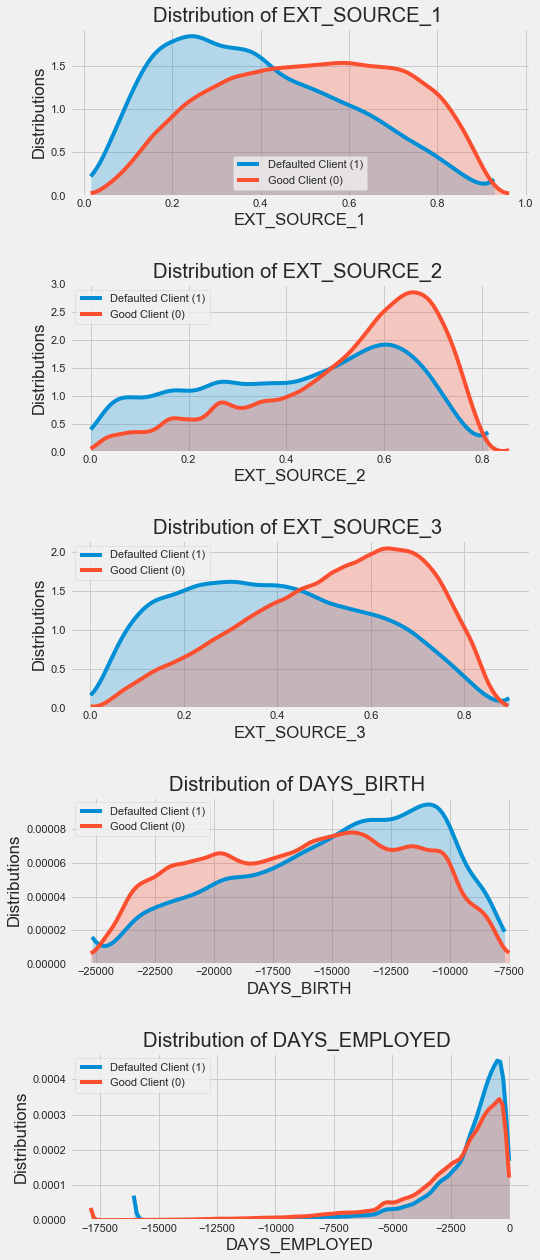

In [13]:
# Top 4 inversely correlated features
kdeplot(train, feature_list = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',"DAYS_BIRTH","DAYS_EMPLOYED"])

Let's look how they are related to each other and the target variable. 

In [20]:
top5features= train[[["TARGET",'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',"DAYS_BIRTH","DAYS_EMPLOYED"]]]


KeyError: "[('TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'DAYS_EMPLOYED')] not in index"

In [19]:
grid = sns.PairGrid(data = top5features, size = 3, diag_sharey=False,
                    hue = 'TARGET')
grid.map_upper(plt.hist, alpha = 0.3)
grid.map_diag(sns.kdeplot)
grid.map_lower(sns.kdeplot)


NameError: name 'top5features' is not defined

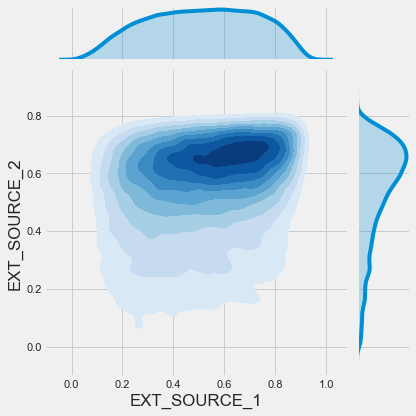

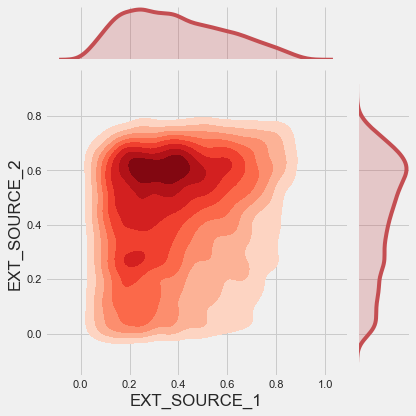

In [17]:

g = sns.JointGrid(x='EXT_SOURCE_1', y='EXT_SOURCE_2', data=train[train.TARGET==0])
g = g.plot_joint(sns.kdeplot, cmap="Blues",  shade=True, shade_lowest=False)
g = g.plot_marginals(sns.kdeplot, shade=True)
g = sns.JointGrid(x='EXT_SOURCE_1', y='EXT_SOURCE_2', data=train[train.TARGET==1])
g = g.plot_joint(sns.kdeplot, cmap="Reds",  shade=True, shade_lowest=False)
g = g.plot_marginals(sns.kdeplot,color="r", shade=True)


In [ ]:
# Here I am building a pipeline

from sklearn_pandas import DataFrameMapper
from sklearn_pandas import CategoricalImputer
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import Imputer

nulls_per_column = train.isnull().sum()
categorical_feature_mask = train.dtypes == object

categorical_columns = train.columns[categorical_feature_mask].tolist()
non_categorical_columns = train.columns[~categorical_feature_mask].tolist()

# Apply numeric imputer
numeric_imputation_mapper = DataFrameMapper([(numeric_feature,Imputer(strategy="median")) for numeric_feature in non_categorical_columns],
                                            input_df=True,
                                            df_out=True
                                           )

# Apply categorical imputer
categorical_imputation_mapper = DataFrameMapper([(category_feature, CategoricalImputer()) for category_feature in categorical_columns],
                                                input_df=True,
                                                df_out=True
                                               )


# Combine the numeric and categorical transformations
numeric_categorical_union = FeatureUnion([
                                          ("num_mapper", numeric_imputation_mapper),
                                          ("cat_mapper", categorical_imputation_mapper)
                                         ])


In [ ]:
numeric_categorical_union
categorical_imputation_mapper

In [ ]:
# Create full pipeline
pipeline = Pipeline([
                     ("featureunion", numeric_categorical_union),
                     ("dictifier", Dictifier()),
                     ("vectorizer", DictVectorizer(sort=False)),
                     ("clf", xgb.XGBClassifier(max_depth=3))
                    ])

### Distribution of target variables in each of the columns in the training dataset

In [ ]:
# Let's see